In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [2]:
df=pd.read_csv('data.csv')
selected_columns = [
    'Make', 'Model', 'Year', 'Engine HP', 'Engine Cylinders',
    'Transmission Type', 'Vehicle Style', 'highway MPG', 'city mpg','MSRP'
]
df = df.loc[:, selected_columns]
df.head()

,Make,Model,Year,Engine HP,Engine Cylinders,Transmission Type,Vehicle Style,highway MPG,city mpg,MSRP
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,46135
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,40650
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,36350
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,29450
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,34500


In [3]:
df.columns = df.columns.str.replace(' ', '_').str.lower()
df.fillna(0, inplace=True)
df.rename(columns={'msrp':'price'}, inplace=True)
df.head()

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,price
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,46135
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,40650
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,36350
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,29450
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,34500


In [4]:
df.isnull().any()

make                 False
model                False
year                 False
engine_hp            False
engine_cylinders     False
transmission_type    False
vehicle_style        False
highway_mpg          False
city_mpg             False
price                False
dtype: bool

In [5]:
df.dtypes

make                  object
model                 object
year                   int64
engine_hp            float64
engine_cylinders     float64
transmission_type     object
vehicle_style         object
highway_mpg            int64
city_mpg               int64
price                  int64
dtype: object

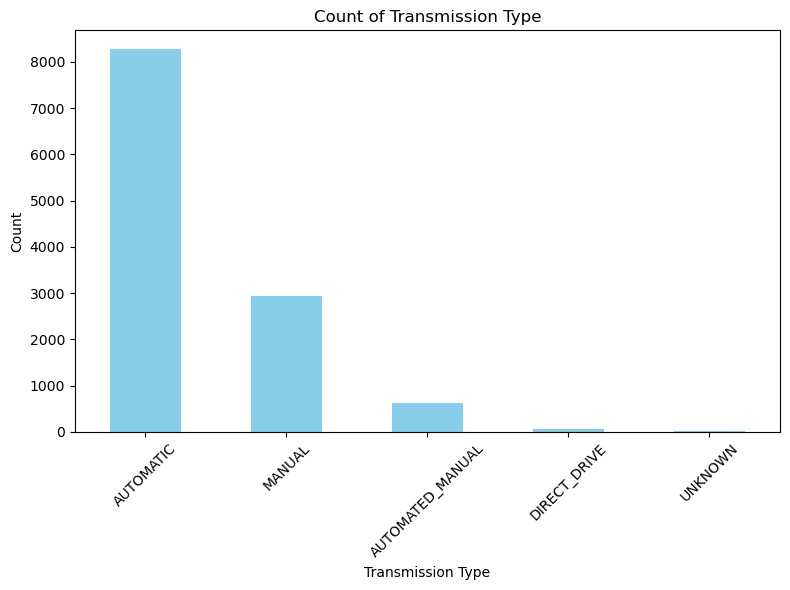

In [6]:
plt.figure(figsize=(8, 6))
df['transmission_type'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Count of Transmission Type')
plt.xlabel('Transmission Type')
plt.ylabel('Count')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

In [7]:
num_feature=['year','engine_hp','engine_cylinders','highway_mpg','city_mpg','price']
cat_feature=['make','model','transmission_type','vehicle_style']

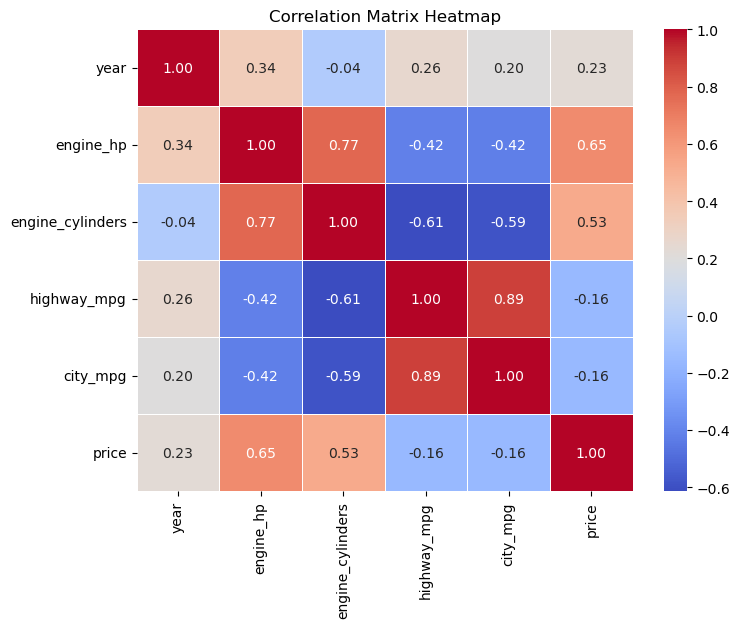

In [8]:
cor_matrix = df[num_feature].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(cor_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [9]:
cor_matrix.unstack().sort_values(ascending = False)

year              year                1.000000
engine_hp         engine_hp           1.000000
city_mpg          city_mpg            1.000000
highway_mpg       highway_mpg         1.000000
engine_cylinders  engine_cylinders    1.000000
price             price               1.000000
city_mpg          highway_mpg         0.886829
highway_mpg       city_mpg            0.886829
engine_hp         engine_cylinders    0.774851
engine_cylinders  engine_hp           0.774851
price             engine_hp           0.650095
engine_hp         price               0.650095
engine_cylinders  price               0.526274
price             engine_cylinders    0.526274
engine_hp         year                0.338714
year              engine_hp           0.338714
                  highway_mpg         0.258240
highway_mpg       year                0.258240
year              price               0.227590
price             year                0.227590
year              city_mpg            0.198171
city_mpg     

# Classification

In [10]:
df['above_average'] = (df['price'] > df['price'].mean()).astype(int)

In [11]:
df_class = df.copy()
mean = df_class['price'].mean()

df_class['above_average'] = np.where(df_class['price']>=mean,1,0)

In [12]:
df_class = df_class.drop('price', axis=1)

In [13]:
df_train_full, df_test = train_test_split(df_class, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=42)

In [14]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [15]:
y_train = df_train.above_average.values
y_val = df_val.above_average.values
y_test = df_test.above_average.values

In [16]:
def calculate_mi(series):
    return mutual_info_score(series, df_train.above_average)

In [17]:
df_mi = df_train[cat_feature].apply(calculate_mi)
df_mi = df_mi.sort_values(ascending=False).to_frame(name='MI')
df_mi     

,MI
model,0.462344
make,0.239769
vehicle_style,0.084143
transmission_type,0.020958


In [20]:
num_feature=['year','engine_hp','engine_cylinders','highway_mpg','city_mpg']
cat_feature=['make','model','transmission_type','vehicle_style']

In [21]:
train_dict = df_train[cat_feature+num_feature].to_dict(orient='records')

dv = DictVectorizer(sparse=False)
dv.fit(train_dict)
X_train = dv.transform(train_dict)

In [25]:
model = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000, random_state=42)
model.fit(X_train, y_train)

val_dict = df_val[cat_feature + num_feature].to_dict(orient='records')
X_val = dv.transform(val_dict)
y_pred = model.predict(X_val)


accuracy = np.round(accuracy_score(y_val, y_pred),2)
print(accuracy)

0.94


In [27]:
features = cat_feature + num_feature

In [29]:
orig_score = accuracy

for c in features:
    subset = features.copy()
    subset.remove(c)
    
    train_dict = df_train[subset].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    dv.fit(train_dict)

    X_train = dv.transform(train_dict)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
    model.fit(X_train, y_train)

    val_dict = df_val[subset].to_dict(orient='records')
    X_val = dv.transform(val_dict)

    y_pred = model.predict(X_val)

    score = accuracy_score(y_val, y_pred)
    print(f"Feature: {c}  Difference: {orig_score - score}  Score: {score}")

Feature: make  Difference: -0.002509441879983254  Score: 0.9425094418799832
Feature: model  Difference: 0.023508182962652113  Score: 0.9164918170373478
Feature: transmission_type  Difference: -0.002089802769618232  Score: 0.9420898027696182
Feature: vehicle_style  Difference: 0.008401174989508986  Score: 0.931598825010491
Feature: year  Difference: -0.008384389425094452  Score: 0.9483843894250944
Feature: engine_hp  Difference: 0.018892152748636093  Score: 0.9211078472513639
Feature: engine_cylinders  Difference: -0.002509441879983254  Score: 0.9425094418799832
Feature: highway_mpg  Difference: -0.0016701636592530988  Score: 0.941670163659253
Feature: city_mpg  Difference: -0.006705832983634141  Score: 0.9467058329836341


# Ridge

In [32]:
df['price']=np.log1p(df['price'])

In [33]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=42)

In [34]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [35]:
y_train = df_train.price.values
y_val = df_val.price.values
y_test = df_test.price.values

In [36]:
num_feature=['year','engine_hp','engine_cylinders','highway_mpg','city_mpg']
cat_feature=['make','model','transmission_type','vehicle_style']

In [37]:
features = cat_feature + num_feature

In [38]:
train_dict = df_train[features].to_dict(orient='records')

In [40]:
dv = DictVectorizer(sparse=False)
dv.fit(train_dict)

X_train = dv.transform(train_dict)

val_dict = df_val[features].to_dict(orient='records')
X_val = dv.transform(val_dict)

In [47]:
for i in [0, 0.01, 0.1, 1, 10]:
    model = Ridge(alpha=i, solver="sag", random_state=42)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_val)
    
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    
    print(f"Alpha: {i}  RMSE: {round(score, 3)}")

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Alpha: 0  RMSE: 0.487


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Alpha: 0.01  RMSE: 0.487


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Alpha: 0.1  RMSE: 0.487


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Alpha: 1  RMSE: 0.487
Alpha: 10  RMSE: 0.487


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
